# Baseline

In [1]:
import numpy as np
from PIL import Image
# Load the data and labels for the first fake dataset
fake_data1_np = np.load('fake_data1.npy')
fake_label1_np = np.load('fake_label1.npy')

# Load the data and labels for the second fake dataset
fake_data2_np = np.load('fake_data2.npy')
fake_label2_np = np.load('fake_label2.npy')

# Load the images and labels
images = np.load('images.npy')
labels = np.load('labels.npy')
test_images= np.load('test_images.npy')
test_labels = np.load('test_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
# train_images = np.concatenate((fake_data1_np, fake_data2_np, images), axis=0)
# train_labels = np.concatenate((fake_label1_np, fake_label2_np, labels), axis=0)
train_images = images
train_labels = labels
train_images_tensor = torch.Tensor(train_images).permute(0, 3, 1, 2) 
train_labels_tensor = torch.Tensor(train_labels).long() 

test_images_tensor = torch.Tensor(test_images).permute(0, 3, 1, 2)
test_labels_tensor = torch.Tensor(test_labels).long()


val_images_tensor = torch.Tensor(val_images).permute(0, 3, 1, 2)
val_labels_tensor = torch.Tensor(val_labels).long()

batch_size = 5 

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
model = models.resnet18(pretrained=True)
num_classes =6
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) 


n_epochs = 100  
best_val_accuracy = 0.0
epoch_loss =[]
valid_accuracy=[]
for epoch in range(n_epochs):  
    model.train()
    running_loss=[]
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # Print statistics
        running_loss.append(loss.item())
    epoch_loss.append(np.mean(running_loss))
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    valid_accuracy.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "baseline_model.pth")
print("Best Accuracy: "+ str(best_val_accuracy))
print('Finished Training')

Best Accuracy: 0.6816666666666666
Finished Training


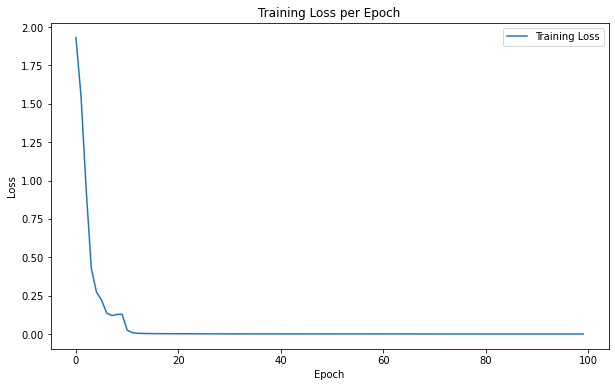

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_loss)), epoch_loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

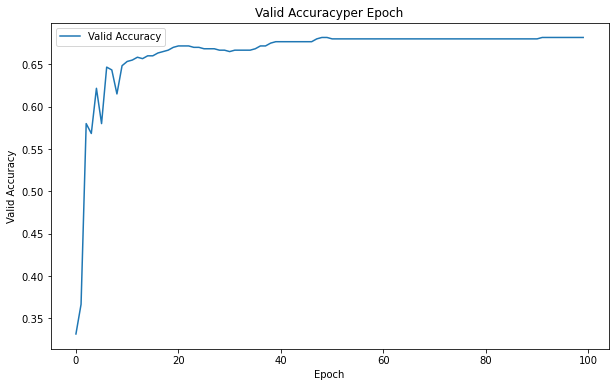

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(valid_accuracy)), valid_accuracy, label='Valid Accuracy')
plt.title('Valid Accuracyper Epoch')
plt.xlabel('Epoch')
plt.ylabel('Valid Accuracy')
plt.legend()
plt.show()

# normal

In [16]:
import numpy as np

# Load the data and labels for the first fake dataset
fake_data1_np = np.load('fake_data1.npy')
fake_label1_np = np.load('fake_label1.npy')

# Load the data and labels for the second fake dataset
fake_data2_np = np.load('fake_data2.npy')
fake_label2_np = np.load('fake_label2.npy')

# Load the images and labels
images = np.load('images.npy')
labels = np.load('labels.npy')
test_images= np.load('test_images.npy')
test_labels = np.load('test_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
transform_augmentation = transforms.Compose([
    # If images are already PIL Images, you don't need the ToPILImage() transform.
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to tensor here.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        return image, label
train_dataset = CustomDataset(train_images, train_labels, transform=transform_augmentation)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
model = models.resnet18(pretrained=True)
num_classes =6
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  

n_epochs = 100  
best_val_accuracy = 0.0
epoch_loss =[]
valid_accuracy=[]
for epoch in range(n_epochs):  
    model.train()
    running_loss=[]
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # Print statistics
        running_loss.append(loss.item())
    epoch_loss.append(np.mean(running_loss))
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    valid_accuracy.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "tradition_model.pth")
print("Best Accuracy: "+ str(best_val_accuracy))
print('Finished Training')

Best Accuracy: 0.6916666666666667
Finished Training


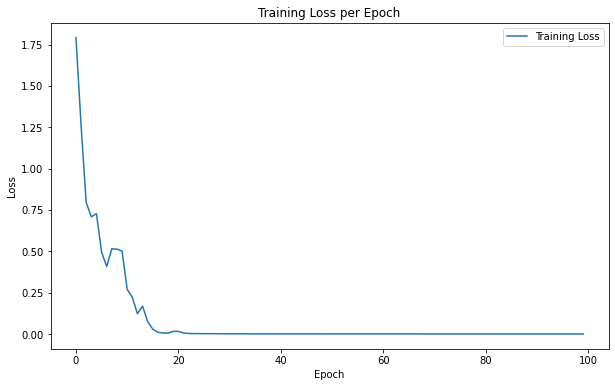

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_loss)), epoch_loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

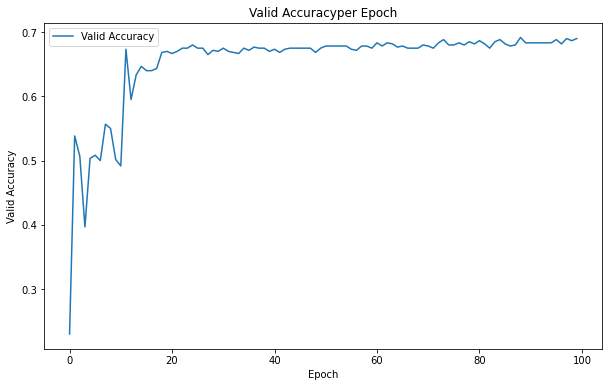

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(valid_accuracy)), valid_accuracy, label='Valid Accuracy')
plt.title('Valid Accuracyper Epoch')
plt.xlabel('Epoch')
plt.ylabel('Valid Accuracy')
plt.legend()
plt.show()

In [20]:
import torch
from torchvision import models
import torch.nn as nn

# Load the trained model
model = models.resnet18(pretrained=False)  
num_classes = 6  
model.fc = nn.Linear(model.fc.in_features, num_classes)  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("tradition_model.pth"))  
model.to(device)
model.eval()  

correct = 0
total = 0
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100}%')

Test Accuracy: 69.83333333333334%


# Fake1+normal

In [21]:
import numpy as np

# Load the data and labels for the first fake dataset
fake_data1_np = np.load('fake_data1.npy')
fake_label1_np = np.load('fake_label1.npy')

# Load the data and labels for the second fake dataset
fake_data2_np = np.load('fake_data2.npy')
fake_label2_np = np.load('fake_label2.npy')

# Load the images and labels
images = np.load('images.npy')
labels = np.load('labels.npy')
test_images= np.load('test_images.npy')
test_labels = np.load('test_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')
images = np.concatenate((fake_data1_np,  images), axis=0)
labels = np.concatenate((fake_label1_np, labels), axis=0)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
transform_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to tensor here.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert the numpy array image to PIL Image
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        return image, label
train_dataset = CustomDataset(train_images, train_labels, transform=transform_augmentation)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = models.resnet18(pretrained=True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  

n_epochs = 100  
best_val_accuracy = 0.0
epoch_loss =[]
valid_accuracy=[]
for epoch in range(n_epochs): 
    model.train()
    running_loss=[]
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()


        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss.append(loss.item())
    epoch_loss.append(np.mean(running_loss))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    valid_accuracy.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "tradition_fake1_model.pth")
print("Best Accuracy: "+ str(best_val_accuracy))
print('Finished Training')

Best Accuracy: 0.7283333333333334
Finished Training


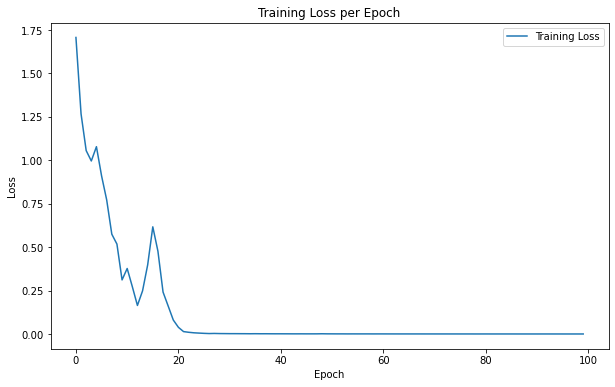

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_loss)), epoch_loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

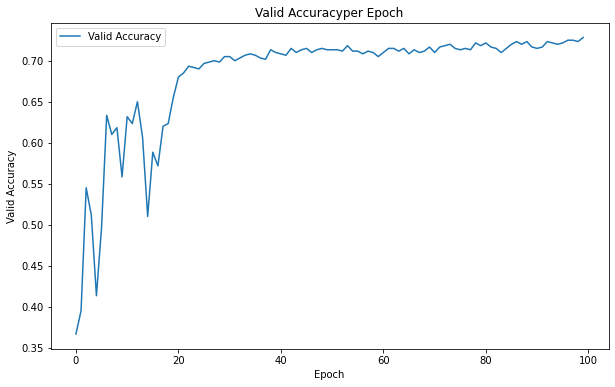

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(valid_accuracy)), valid_accuracy, label='Valid Accuracy')
plt.title('Valid Accuracyper Epoch')
plt.xlabel('Epoch')
plt.ylabel('Valid Accuracy')
plt.legend()
plt.show()

In [24]:
import torch
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=False) 
num_classes = 6  
model.fc = nn.Linear(model.fc.in_features, num_classes)  #

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("tradition_fake1_model.pth"))  # Load the saved model weights
model.to(device)
model.eval()  

correct = 0
total = 0
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100}%')

Test Accuracy: 71.5%


In [25]:
import numpy as np

# Load the data and labels for the first fake dataset
fake_data1_np = np.load('fake_data1.npy')
fake_label1_np = np.load('fake_label1.npy')

# Load the data and labels for the second fake dataset
fake_data2_np = np.load('fake_data2.npy')
fake_label2_np = np.load('fake_label2.npy')

# Load the images and labels
images = np.load('images.npy')
labels = np.load('labels.npy')
test_images= np.load('test_images.npy')
test_labels = np.load('test_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')
images = np.concatenate((fake_data2_np,  images), axis=0)
labels = np.concatenate((fake_label2_np, labels), axis=0)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
transform_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to tensor here.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        return image, label
train_dataset = CustomDataset(train_images, train_labels, transform=transform_augmentation)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = models.resnet18(pretrained=True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) 

n_epochs = 100  
best_val_accuracy = 0.0
epoch_loss =[]
valid_accuracy=[]
for epoch in range(n_epochs):  
    model.train()
    running_loss=[]
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()


        running_loss.append(loss.item())
    epoch_loss.append(np.mean(running_loss))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    valid_accuracy.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "tradition_fake2_model.pth")
print("Best Accuracy: "+ str(best_val_accuracy))
print('Finished Training')

Best Accuracy: 0.6966666666666667
Finished Training


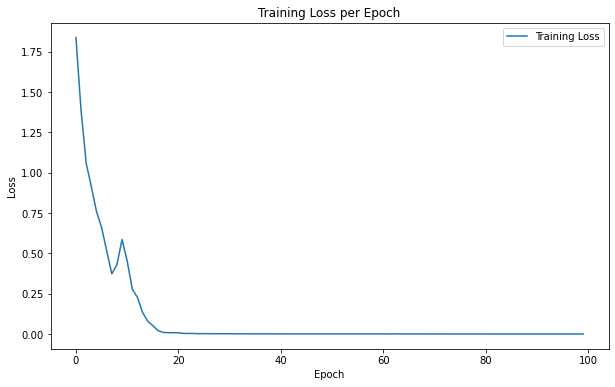

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(epoch_loss)), epoch_loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

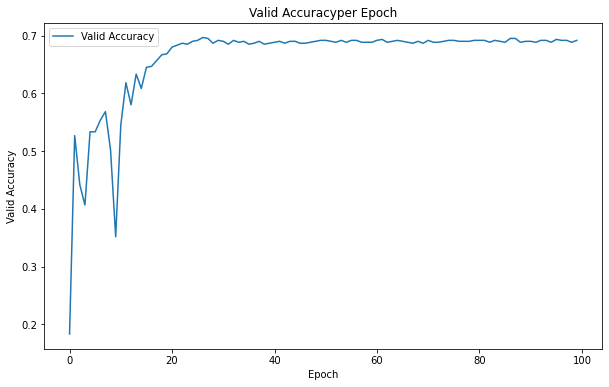

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(valid_accuracy)), valid_accuracy, label='Valid Accuracy')
plt.title('Valid Accuracyper Epoch')
plt.xlabel('Epoch')
plt.ylabel('Valid Accuracy')
plt.legend()
plt.show()

In [28]:
import torch
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=False)  
num_classes = 6 
model.fc = nn.Linear(model.fc.in_features, num_classes)  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("tradition_fake2_model.pth"))  
model.to(device)
model.eval()  


correct = 0
total = 0
with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100}%')

Test Accuracy: 66.83333333333333%
